# COVID-19 Classification

This dataset contains X-ray scans from 3 classes: COVID-19, Viral Pneumonia, Normal. We will train a deep learning model to classify an image as one of three classes.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-03-05 23:06:12.599802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In the original dataset, the images have different dimensions. Thus, we standardize the training and testing samples by reshaping each to have dimensions (1000,1000).

In [2]:
LABELS = ['Normal', 'Covid', 'Viral Pneumonia']
CROP_HEIGHT = 1000
CROP_WIDTH = 1000

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='data/Covid19-dataset/train/',
    batch_size=1,
    image_size=(CROP_WIDTH, CROP_HEIGHT),
    label_mode='categorical',
    shuffle=True,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='data/Covid19-dataset/test/',
    batch_size=1,
    image_size=(CROP_WIDTH, CROP_HEIGHT),
    label_mode='categorical',
    shuffle=False,
)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


2023-03-05 23:06:25.495056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[0. 0. 1.]]


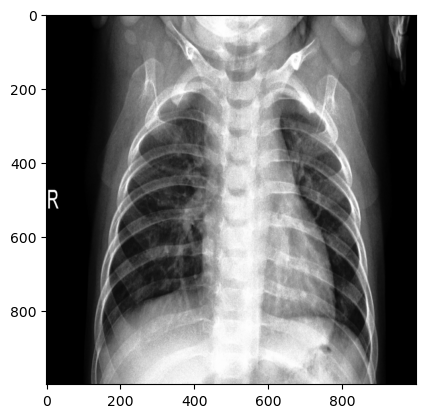

In [5]:
for image_raw, label in train_data.take(1):
    img = image_raw.numpy().astype(np.uint32)[0]
    plt.imshow(img)
    print(label.numpy())

## Model

We use a MobileNetV2 model architecture pretrained on the Imagenet dataset as a base model. We apply global average pooling to the last layer, and add a softmax layer with 3 nodes corresponding to the classes. During training, we freeze all weights except for this last layer.

In [6]:
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False

input_ = tf.keras.layers.Input(shape=(CROP_WIDTH, CROP_HEIGHT, 3))
x = base_model(input_, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
output = tf.keras.layers.Dense(len(LABELS), activation='softmax')(x)

model = tf.keras.Model(input_, output)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 1000, 3)]   0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
hist = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
251/251 [==============================] - 117s 453ms/step - loss: 0.6775 - accuracy: 0.7371 - val_loss: 0.5255 - val_accuracy: 0.7576
Epoch 2/10
251/251 [==============================] - 112s 444ms/step - loss: 0.3801 - accuracy: 0.8924 - val_loss: 0.4218 - val_accuracy: 0.8333
Epoch 3/10
251/251 [==============================] - 112s 447ms/step - loss: 0.2858 - accuracy: 0.9163 - val_loss: 0.3656 - val_accuracy: 0.8636
Epoch 4/10
251/251 [==============================] - 112s 446ms/step - loss: 0.2285 - accuracy: 0.9283 - val_loss: 0.2779 - val_accuracy: 0.8788
Epoch 5/10
251/251 [==============================] - 112s 447ms/step - loss: 0.1966 - accuracy: 0.9482 - val_loss: 0.2834 - val_accuracy: 0.9091
Epoch 6/10
251/251 [==============================] - 112s 447ms/step - loss: 0.1693 - accuracy: 0.9562 - val_loss: 0.2723 - val_accuracy: 0.9242
Epoch 7/10
251/251 [==============================] - 112s 447ms/step - loss: 0.1458 - accuracy: 0.9641 - val_loss: 0.1926 -

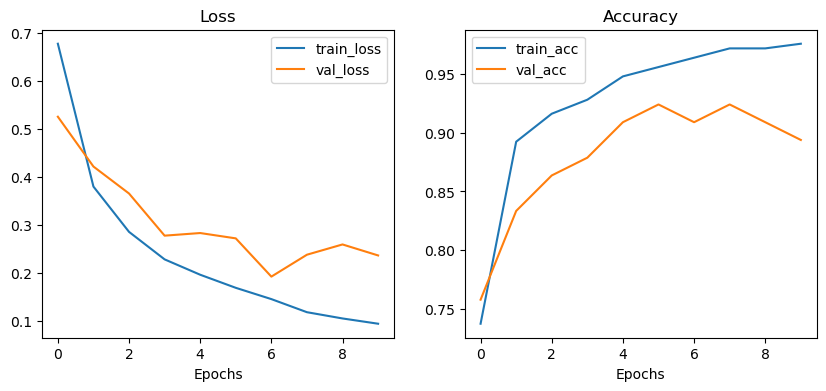

In [14]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]

epochs = range(len(hist.history['loss']))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## Evaluation

In [16]:
test_predictions = model.predict(test_data)

66/66 [==============================] - 28s 407ms/step


In [17]:
test_predictions.argmax(axis=-1)

array([0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1])

In [18]:
test_images = []
test_labels = []

for image, label in test_data:
    test_images.append(image.numpy()[0])
    test_labels.append(label.numpy().argmax())

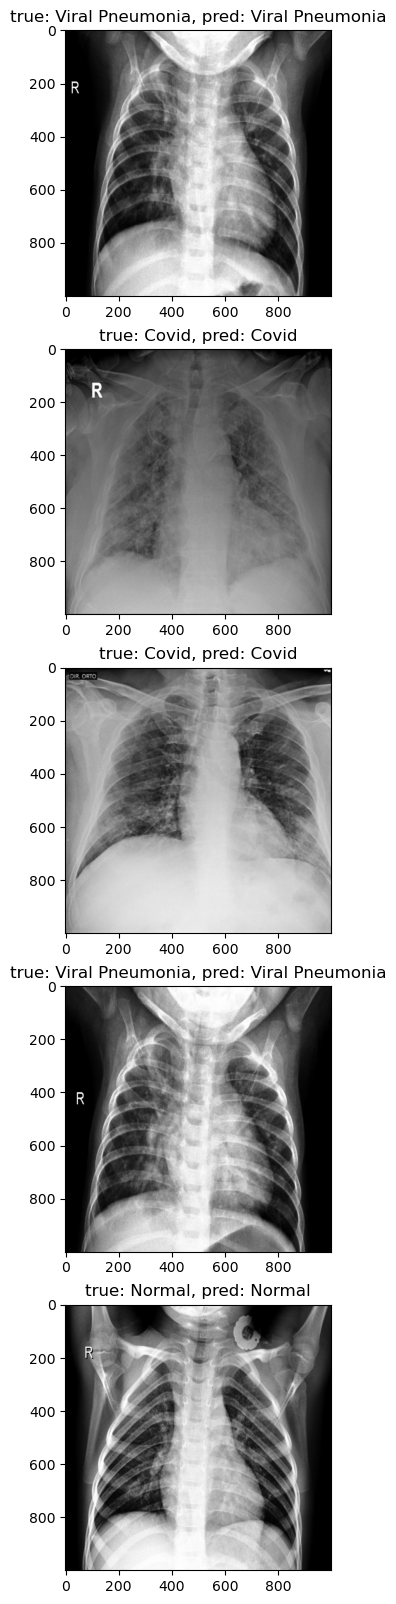

In [19]:
plt.figure(figsize=(10,20))

for i, j in enumerate(np.random.choice(np.arange(len(test_predictions)), 5)):
    plt.subplot(5,1,i+1)
    plt.imshow(test_images[j].astype(np.int32))
    plt.title(f'true: {LABELS[test_labels[j]]}, pred: {LABELS[test_predictions[j].argmax()]}')
plt.show()